# Using CMBLensing.jl from Python

If you predominantly use Python, it's very easy to call CMBLensing.jl directly from your Python session. This is made possible by the [PyJulia](https://pyjulia.readthedocs.io/en/latest/index.html) package. You can install it into your Python environment with, e.g.:

```shell
$ pip install --user julia
```

**Important:** If your Python executable is statically-linked (this is quite often the case, e.g. its the default on Ubuntu and Conda) you need one extra step. Basically, instead of running `python` or `ipython` at the command line to launch your interpreter, run `python-jl`  or `python-jl -m IPython`, respectively. These wrapper scripts set up a few extra things before dropping you into the Python/IPython interpreter that you are familiar with. 


For Jupyter notebooks, you can install a Jupyter kernel which uses `python-jl` with

```shell
python -m julia.ipykernel install --python-jl
```

The [PyJulia docs](https://pyjulia.readthedocs.io/en/latest/troubleshooting.html#your-python-interpreter-is-statically-linked-to-libpython) also give instructions on two other ways to solve this issue, including a pretty easy way to install a dynamically-linked Python executable which is the most ideal solution, but slightly more work than above. 

## Basics of calling Julia

Once PyJulia is installed, you can access any Julia package `Foo` from the Python package `julia.Foo`, and everything pretty much works transparently.

In [10]:
import julia.Base

In [15]:
julia.Base.cos(1) # <--- this is Julia's cosine function

0.5403023058681398

You can also run arbitrary Julia code with the `%julia` cell magic (this is helpful if you want to use Julia language features or syntax which don't exist in Python):

In [25]:
%load_ext julia.magic

The julia.magic extension is already loaded. To reload it, use:
  %reload_ext julia.magic


For example, `1:10` is not valid Python syntax, but we can do:

In [26]:
%julia 1:10

range(1, 11)

The cell magic lets you interpolate values from Python into the Julia expression, which can be a convenient way to pass values back and forth:

In [18]:
x = %julia 1 + 2

In [19]:
%julia 2 * $x

6

## Calling CMBLensing.jl

In Julia, `using CMBLensing` imports all of the CMBLensing symbols into the current namespace. In Python this is:

In [50]:
from julia.CMBLensing import *

Things then generally work the same as in Julia. For example, following [this](../lense_a_map/) example, we load a simulated dataset:

In [21]:
sim = load_sim_dataset(
    θpix  = 2, 
    Nside = 256, 
    T     = julia.Base.Float32, 
    use   = "P"
)

Note however we did have to use `julia.Base.Float32` instead of just `Float32` since that is a Julia type and it's not exported in CMBLensing. 

The next step in the example is to "unpack" the variables in the `sim` objects for convenience, i.e.

```julia
# julia code:
@unpack f, ϕ, ds = sim
```

There's two problems doing this in Python. First, there's no macro `@unpack` so we have to do it by hand. Second, Python does not differentiate between the characters `ϕ (\phi)` and `φ (\varphi)`, and maps both of them back to `φ (\varphi)` in Julia, which unfortunately is the wrong one for CMBLensing (which instead makes extensive use of the variable name `ϕ (\phi)`)

To get around this, we can wrap code which needs to access  `ϕ (\phi)` in `%julia` magic. The whole thing thus looks like:

In [27]:
f, ϕ, ds = %julia $sim.f, $sim.ϕ, $sim.ds

Plotting works the same. We first enable inline plotting:

In [57]:
%pylab inline --no-import-all
%config InlineBackend.rc = {"figure.dpi": 100} # this matches default Julia DPI

Populating the interactive namespace from numpy and matplotlib


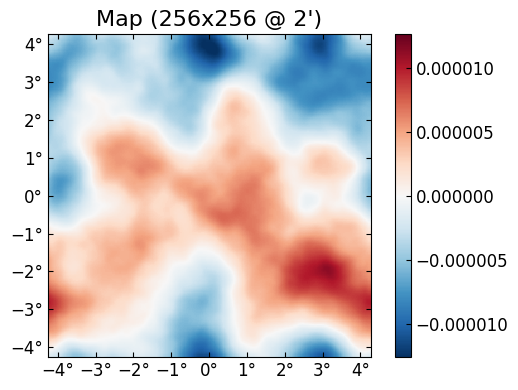

In [59]:
plot(ϕ);

The call to `from julia.CMBLensing import *` only import CMBLensing into the Python namespace, if we want to use CMBLensing functions from `%julia` blocks we also need to load it there.

In [34]:
%julia using CMBLensing

In [35]:
Lϕ = %julia LenseFlow($ϕ)

In Julia you can do addition / multiplication / etc... with operators and fields. This does not work in PyJulia (yet), so you need to use `%julia` magic:

In [37]:
f̃ = %julia $Lϕ * $f

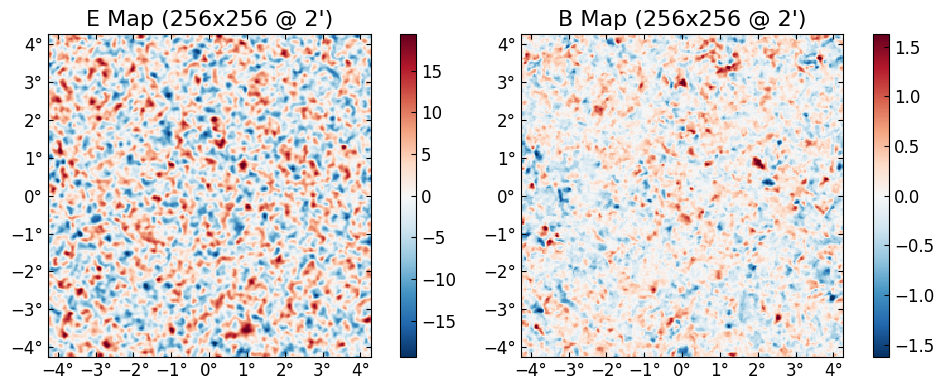

In [38]:
plot(f̃);

## Beyond

This should give you all the tools needed to run any of the other examples in CMBLensing docs from Python. As a general rule, try doing things natively from Python, and if that doesn't work, wrap things in `%julia` magic to just call the Julia code directly.